# Video Classification with a CNN-RNN Architecture

**Author:** Junfeng Zhang

**Last modified:** 25/10/2022<br>
**Description:** Training a video classifier using CNN and RNN.

Video tutorials and documentations referenced:


*   https://www.youtube.com/watch?v=QmtSkq3DYko&t=3371s
*   https://www.youtube.com/watch?v=ezjnySXqdTo
*   https://keras.io/api/layers/recurrent_layers/conv_lstm2d/





Notes:




1.   Data imbalanced to balanced. 
2.   sequence length tried 20, 30, 40





In [1]:
!pip install -q git+https://github.com/tensorflow/docs

## Conecting to Google Drive



In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Test data loading to make sure Google Drive is mounted correctly. 
!ls "/content/drive/My Drive/cnn_lstm/class1/"

class1_batch_0_video3.avi   class1_batch_1_video5.avi
class1_batch_0_video4.avi   class1_batch_1_video6.avi
class1_batch_0_video5.avi   class1_batch_23_video1.avi
class1_batch_0_video6.avi   class1_batch_24_video6.avi
class1_batch_10_video1.avi  class1_batch_24_video7.avi
class1_batch_10_video2.avi  class1_batch_24_video8.avi
class1_batch_10_video3.avi  class1_batch_26_video1.avi
class1_batch_10_video4.avi  class1_batch_26_video2.avi
class1_batch_10_video5.avi  class1_batch_26_video3.avi
class1_batch_10_video6.avi  class1_batch_26_video4.avi
class1_batch_10_video7.avi  class1_batch_26_video5.avi
class1_batch_10_video8.avi  class1_batch_26_video6.avi
class1_batch_11_video1.avi  class1_batch_26_video7.avi
class1_batch_11_video2.avi  class1_batch_3_video1.avi
class1_batch_11_video3.avi  class1_batch_3_video2.avi
class1_batch_11_video4.avi  class1_batch_3_video3.avi
class1_batch_11_video5.avi  class1_batch_3_video4.avi
class1_batch_11_video6.avi  class1_batch_3_video5.avi
class1_batch_12_v

In [4]:
!ls "/content/drive/My Drive/cnn_lstm/class0/"

class0_batch_0_video1.avi   class0_batch_19_video5.avi
class0_batch_0_video2.avi   class0_batch_19_video6.avi
class0_batch_10_video1.avi  class0_batch_19_video7.avi
class0_batch_11_video1.avi  class0_batch_19_video8.avi
class0_batch_11_video2.avi  class0_batch_19_video9.avi
class0_batch_11_video3.avi  class0_batch_1_video1.avi
class0_batch_11_video4.avi  class0_batch_1_video2.avi
class0_batch_11_video5.avi  class0_batch_1_video3.avi
class0_batch_11_video6.avi  class0_batch_1_video4.avi
class0_batch_11_video7.avi  class0_batch_1_video5.avi
class0_batch_11_video8.avi  class0_batch_1_video6.avi
class0_batch_11_video9.avi  class0_batch_1_video7.avi
class0_batch_12_video1.avi  class0_batch_1_video8.avi
class0_batch_13_video1.avi  class0_batch_21_video1.avi
class0_batch_13_video2.avi  class0_batch_21_video2.avi
class0_batch_13_video3.avi  class0_batch_21_video3.avi
class0_batch_13_video4.avi  class0_batch_21_video4.avi
class0_batch_13_video5.avi  class0_batch_21_video5.avi
class0_batch_13_vi

## Setup

In [5]:
# Import all dependencies
import cv2
import os
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from tensorflow import keras
from imutils import paths
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix 

## Define hyperparameters

In [6]:
# Set random seed to make the sample reproducible
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [7]:
# Based on the 10-second 30 fps videos we have. 
MAX_SEQ_LENGTH = 300

# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 224, 224

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

In [8]:

# Specify the directory containing the dataset. 
DATA_DIR = "/content/drive/My Drive/cnn_lstm"

# Specify the list containing the names of the classes used for training. Class0 for alert, Class1 for Drowsy.
CLASSES_LIST = ["class0", "class1"]

## Data preparation

In [9]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video
    Returns:
        frames: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    frames_to_skip = max(int(total_frames/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * frames_to_skip)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame pixel values to between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames

In [10]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indecies of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos.
    '''

    # Declared Empty Lists to store the output values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_id, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files  in the specific class dir.
        files_list = os.listdir(os.path.join(DATA_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATA_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # ensure enough frames have been extracted.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_id)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [11]:
# Call the function above to extract features
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: class0
Extracting Data of Class: class1


In [12]:
# expanding the dimension to feed into the models 
reshape_features = features[None,...]
features.shape

(176, 20, 224, 224, 3)

In [13]:
#one_hot_encoded_labels
one_hot_encoded_labels = to_categorical(labels)


In [14]:
# Train test split. 
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [15]:
features_train.shape

(132, 20, 224, 224, 3)

In [16]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: the constructed convlstm model.
    '''

    # Using Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(2, activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [17]:
# Construct the convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 222, 222, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 111, 111, 4)  0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 111, 111, 4)  0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 109, 109, 8)   3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 55, 55, 8)    0         
 3D)                                                             
                                                        

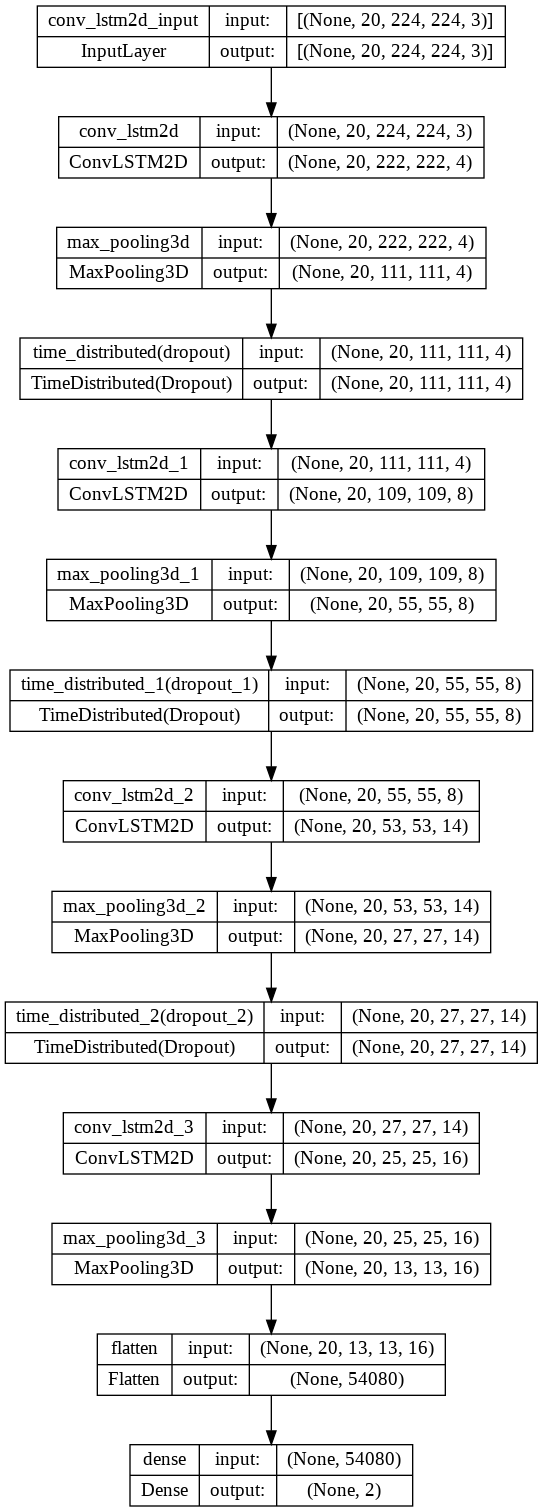

In [18]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [19]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model. 'categorical_crossentropy' is good for one hot encoded categories.
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 40, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback]
                                                     )

Epoch 1/40
27/27 [==============================] - 33s 509ms/step - loss: 0.7220 - accuracy: 0.5524 - val_loss: 0.7397 - val_accuracy: 0.2963
Epoch 2/40
27/27 [==============================] - 12s 433ms/step - loss: 0.7020 - accuracy: 0.5048 - val_loss: 0.7579 - val_accuracy: 0.2963
Epoch 3/40
27/27 [==============================] - 12s 437ms/step - loss: 0.7256 - accuracy: 0.5048 - val_loss: 0.7068 - val_accuracy: 0.2963
Epoch 4/40
27/27 [==============================] - 12s 438ms/step - loss: 0.7033 - accuracy: 0.5238 - val_loss: 0.6929 - val_accuracy: 0.4444
Epoch 5/40
27/27 [==============================] - 12s 438ms/step - loss: 0.6472 - accuracy: 0.6952 - val_loss: 0.7223 - val_accuracy: 0.5926
Epoch 6/40
27/27 [==============================] - 12s 440ms/step - loss: 0.6556 - accuracy: 0.5810 - val_loss: 0.5883 - val_accuracy: 0.7037
Epoch 7/40
27/27 [==============================] - 12s 436ms/step - loss: 0.5343 - accuracy: 0.7429 - val_loss: 0.6500 - val_accuracy: 0.6667

In [20]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

2/2 [==============================] - 1s 167ms/step - loss: 0.3037 - accuracy: 0.9318


In [21]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history


# Get the current Date and Time in a DateTime Object for saving the model. 
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_str = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a informative name for the model for better tracking
model_file_name = f'convlstm_model___Date_Time_{current_date_time_str}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(os.path.join(DATA_DIR, model_file_name))

In [22]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    # Get metric values using metric names.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

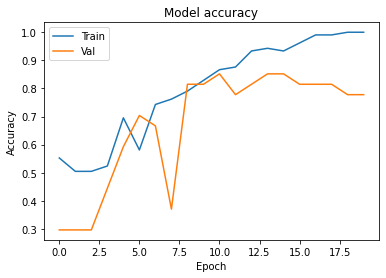

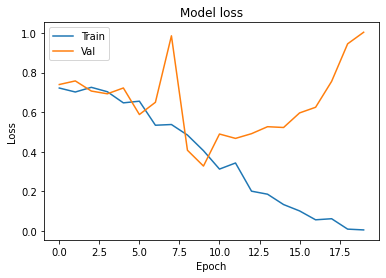

In [23]:
#Team standard plot. 

# Plot training & validation accuracy values
plt.plot(convlstm_model_training_history.history['accuracy'])
plt.plot(convlstm_model_training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(convlstm_model_training_history.history['loss'])
plt.plot(convlstm_model_training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [24]:
# Confusion Matrix

predictions = convlstm_model.predict(features_test)  
predictions = [ np.argmax(x) for x in predictions]
predicted_classes = np.array(predictions)
test_classes = np.argmax(labels_test, axis=1)

print()
print("Accuracy:", metrics.accuracy_score(test_classes, predicted_classes))
print("\n","Confusion Matrix:", "\n", confusion_matrix(test_classes, predicted_classes))  
print("\n","classification_report:", "\n", classification_report(test_classes, predicted_classes))  

2/2 [==============================] - 1s 101ms/step

Accuracy: 0.9318181818181818

 Confusion Matrix: 
 [[18  2]
 [ 1 23]]

 classification_report: 
               precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.92      0.96      0.94        24

    accuracy                           0.93        44
   macro avg       0.93      0.93      0.93        44
weighted avg       0.93      0.93      0.93        44



# Prediction

Defining functions for prediction on video files for testing. This will be transformed into prediction with camera capture.

In [25]:
def predict_with_convlstm_model(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video file using the ConvLSTM model.
    Args:
    video_file_path:  The path of the video to be classified. 
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Get the number of frames in the video.
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    frames_to_skip = max(int(total_frames/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * frames_to_skip)

        # Read a frame.
        success, frame = video_reader.read() 

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    # Release the VideoCapture object. 
    video_reader.release()

In [26]:
# Construct tihe nput youtube video path
input_video_file_path = f'/content/drive/My Drive/cnn_lstm/class1/class1_batch_8_video2.avi'

# Perform Single Prediction on the Test Video.
predict_with_convlstm_model(input_video_file_path, SEQUENCE_LENGTH)



1/1 [==============================] - 0s 69ms/step
Action Predicted: class1
Confidence: 0.8847906589508057


In [27]:
# Construct tihe nput youtube video path
input_video_file_path = f'/content/drive/My Drive/cnn_lstm/class0/class0_batch_1_video6.avi'

# Perform Single Prediction on the Test Video.
predict_with_convlstm_model(input_video_file_path, SEQUENCE_LENGTH)



1/1 [==============================] - 0s 67ms/step
Action Predicted: class0
Confidence: 0.9492344856262207
